In [3]:
# Name - Dev Patel
# Roll No - 18110113

import numpy as np
import scipy
import scipy.integrate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [4]:
# Some constants
l1 = 0.25
l2 = 0.25
l3 = 0.25
g = 9.81
m1 = 100
m2 = 100
m3 = 100
m = 100
r = 0.01
q1 = 0
q2 = 0
d3 = 0
q1_I = 0
q2_I = 0
d3_I = 0
omega1 = 0
omega2 = 0
d3_dot = 0
d1 = 0.25
I1 = m*r*r/2 + m1*l1*l1/12
I2 = m2*l2*l2/12
I3 = m3*r*r/2


# User Inputs
Coordinates= list(map(float, input("Initial End effector position:").split()))
P_i = np.array(Coordinates)

Coordinates= list(map(float, input("Final End effector position:").split()))
P_f = np.array(Coordinates)

In [5]:
# Get a skew symmetric matrix for a given 3x1 matrix
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

#SCARA
def inverse_kinematics_SCARA(O):

    c2 = (O[0]**2 + O[1]**2 - l1**2 - l2**2)/(2*l1*l2)
    theta2 = np.arctan2(-(1-c2**2)**0.5,c2)
    theta1 = np.arctan2(O[1],O[0]) - np.arctan2(l2*np.sin(theta2),l1 + l2*np.cos(theta2))

    d3 = d1 - O[2] 

    I = np.array([theta1,theta2,d3])
    return(I)

q_i = inverse_kinematics_SCARA(P_i)
q_f = inverse_kinematics_SCARA(P_f)

# Get the jacobian matrix for a robot
def Jacobian_SCARA(DH_parameters):
    T = np.eye(4)
    O = np.array([0,0,0])
    Z = np.array([0,0,1])
    for i in range(4):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])

        T = np.dot(T,A)
        O = np.c_[O,np.transpose(T[:3,3])]
        Z = np.c_[Z,np.transpose(T[:3,2])]
    J = np.r_[np.dot(skew(Z[:,0]),np.transpose(O[:,3]) - np.transpose(O[:,0])), np.transpose(Z[:,0])]
    for i in range(1,4):
        if(i==4):
             J = np.c_[J,np.r_[np.transpose(Z[:,i]),np.transpose([0,0,0])]]
        else:
            J = np.c_[J,np.r_[np.dot(skew(Z[:,i]),np.transpose(O[:,3]) - np.transpose(O[:,i])), np.transpose(Z[:,i])]]
    return(J)

def end_Effector_position_SCARA(I):
    T = np.eye(4)
    DH_parameters = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l1,0,3.14],[0,0,I[2],0]])
    for i in range(4):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])

        T = np.dot(T,A)
    return(T[0:3,3])


In [12]:
def SCARAmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    d3_dot = y[8]
    omega2 = y[7]
    omega1 = y[6]
    d3 = y[5]
    q2 = y[4]
    q1 = y[3]
    d3_I = y[2]
    q2_I = y[1]
    q1_I = y[0]

    d11 = (m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2)
    d12 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2)
    d22 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3
    d23 = I3
    d33 = m3/4

    B =  -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega2 - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega2*omega2
    C = (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega1/2
    K1 = 0.1 #integral constant
    K2 = 100 # differential constant
    K = -100 # linear constant
    
    dydt = [q1,q2, d3, omega1, omega2, d3_dot, (-B - d12*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d11 - I1) - K*(q_f[0]-q1) - K1*q1_I - K2*omega1, (d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) - K*(q_f[1] - q2) - K1*q2_I - K2*omega2, (-1 - d23*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d33 - I3) - K*(q_f[2] - d3)- K1*d3_I - K2*d3_dot]
    
    return dydt

q1 = q_i[0]
q2 = q_i[1]
d3 = q_i[2]
    
initstate = [q1_I,q2_I,d3_I,q1,q2, d3, omega1, omega2, d3_dot] # initial states
timestep = 0.1

time = np.linspace(0, 10, 1000) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(SCARAmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[3]
qs2 = solution.y[4]
ds3 = solution.y[5]
omegas1 = solution.y[6]
omegas2 = solution.y[7]
ds3_dot = solution.y[8]
time = solution.t


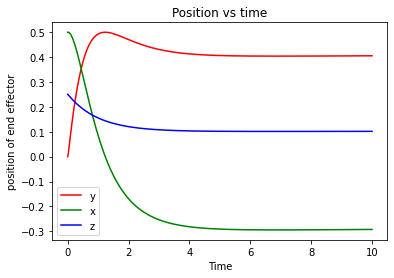

In [13]:
# For plotting the plots of end effector position
X = []
Y = []
Z = []

for i in range(len(qs1)):
    q1 = qs1[i]
    q2 = qs2[i]
    d3 = ds3[i]
    E = end_Effector_position_SCARA([q1,q2,d3])
    X.append(E[0])
    Y.append(E[1])
    Z.append(E[2])


plt.plot(time,Y,'r',time,X,'g',time,Z,'b')
plt.title('Position vs time')
plt.xlabel('Time')
plt.ylabel("position of end effector")
plt.legend(['y','x','z'])
plt.show()

In [ ]:
# Planar visualization.
%matplotlib tk
plt.ion()
plt.show()

for i in range(len(qs1)):
    q1 = qs1[i]
    q2 = qs2[i]
    d3 = ds3[i]

    # position of the links 
    ballpos1 = (l1*np.cos(q1),l1*np.sin(q1))
    ballpos2 = (l1*np.cos(q1) + l2*np.cos(q1+q2), l1*np.sin(q1) + l2*np.sin(q1+q2))

    plt.clf() # clear figure before each plot

    # set axis limits. 
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

    # plot the 2R Manipulator
    hinge = (0, 0)
    plt.plot([hinge[0], ballpos1[0], ballpos2[0]], [hinge[1], ballpos1[1], ballpos2[1]], '-o')

    # pause so that the figure can be seen
    plt.pause(0.0001)

plt.ioff()
plt.show()